In [1]:
import os
import sys
import datacube
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from otps import TimePoint
from otps import predict_tide
from dateutil.relativedelta import relativedelta
from collections import Counter
import warnings

sys.path.append('../10_Scripts')
import SpatialTools, DEAPlotting

# Create datacube instance
dc = datacube.Datacube(app='Tidal geomedian filmstrips')
dc_upgrade = datacube.Datacube(config='/home/561/rt1527/.ard-interoperability_tmp.conf')


def date_range(start_date, end_date, freq = '1YS'):
    
    '''
    Generates a dictionary of from-to date ranges based on a start and end date, and
    a temporal frequency (e.g. annually or six-monthly etc).
    
    Frequencies are based on Panda's date offset objects - see the following list:
    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects.
    Options include annual ('1YS'), every 6 months ('6MS') etc.
    
    Outputs a dictionary with each time range named by its starting date.
    '''    

    # Convert to list of from-to dates. 
    from_dates = pd.date_range(start_date, end_date, freq=freq)[:-1].astype(str).values
    to_dates = pd.date_range(start_date, end_date, freq=freq)[1:].astype(str).values
    
    # Combine into a dictionary. Starting dates for each range are used to name output files.
    date_ranges = {a: (a, b) for (a, b) in np.dstack([from_dates, to_dates])[0]}
    
    return date_ranges


def mostcommon_utm(dc, product, query):    
    
    '''
    Takes a given query and returns the most common UTM zone for 
    observations returned for that spatial extent.
    
    '''
    
    # List of matching products
    matching_datasets = dc.find_datasets(product=product, **query)
    
    # Extract all CRSs
    crs_list = [str(i.crs) for i in matching_datasets]    
   
    # Identify most common CRS
    crs_counts = Counter(crs_list)    
    crs_mostcommon = crs_counts.most_common(1)[0][0]

    # Warn user if multiple CRSs are encountered
    if len(crs_counts.keys()) > 1:

        warnings.warn(f'Multiple UTM zones {list(crs_counts.keys())} were returned for this query.' 
                      f'Defaulting to the most common zone: {crs_mostcommon}', UserWarning)
    
    return crs_mostcommon


def tidal_tag(ds, tidepost_lat=None, tidepost_lon=None, swap_dims=False):
    
    if not tidepost_lat or not tidepost_lon:
        
        tidepost_lon, tidepost_lat = ds.extent.centroid.to_crs(crs=CRS('EPSG:4326')).coords[0]
        print(f'Setting tide post from dataset centroid: {tidepost_lon}, {tidepost_lat}')
        
    else:
        print(f'Using user-supplied tide post: {tidepost_lon}, {tidepost_lat}')
    
    # Use the tidal mode to compute tide heights for each observation:
    obs_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()
    obs_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in obs_datetimes]
    obs_predictedtides = predict_tide(obs_timepoints)
    obs_tideheights = [predictedtide.tide_m for predictedtide in obs_predictedtides]

    # Assign tide heights to the dataset as a new variable
    ds['tide_heights'] = xr.DataArray(obs_tideheights, [('time', ds.time)])
    
    # If swap_dims = True, make tide height the primary dimension instead of time
    if swap_dims:
        
        # Swap dimensions and sort by tide height
        ds = ds.swap_dims({'time': 'tide_heights'})
        ds = ds.sortby('tide_heights')        
    
    return ds


## Set spatial query

In [2]:
# Option 1: For a set of discontinuous or unevenly sized time steps (e.g. climatic periods, before-after development):
study_area = 'cabarita_custom'  # name used as prefix for output files
lat_extents = (-29.26, -29.31)
lon_extents = (153.33, 153.38)
date_ranges = {'elnino_1': ('2011-01-01', '2012-01-01'),
               'lanina_1': ('2013-01-01', '2014-01-01'),
               'elnino_2': ('2015-01-01', '2016-01-01')}

# Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
study_area = 'cabarita_annual'  # name used as prefix for output files
lat_extents = (-29.26, -29.31)
lon_extents = (153.33, 153.38)
date_ranges = date_range('2010-01-01', '2019-01-01', freq = '1YS')

# Preview area
DEAPlotting.display_map(x=lon_extents, y=lat_extents, crs='EPSG:4326')

## Load satellite data

In [3]:
# Base query
query = {'y': lat_extents,
         'x': lon_extents,
         'crs': 'EPSG:4326',
         'time': ('1986-01-01', '2020-01-01')}

# Obtain output CRS by taking the most common value of matching Landsat 5 observations
output_crs = mostcommon_utm(dc=dc_upgrade, product='ls5_ard', query=query)

# Output dicts to hold entire time-series for each sensor
sensor_dict = {}

# For each sensor, dask load data and compute tide heights for each sensor
for sensor in ['ls5', 'ls7', 'ls8']:    
  
    # Return observations matching query without actually loading them using dask
    sensor_all = dc_upgrade.load(product='{}_ard'.format(sensor), 
                                 measurements=['nbart_red', 'nbart_blue', 'nbart_green', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2', 'fmask'],
                                 group_by='solar_day', 
                                 output_crs=output_crs,
                                 resolution=(-30, 30),
                                 gqa_iterative_mean_xy=(0, 1),  # Tolerate no more than a one pixel shift
                                 align=(15, 15),  # Fix for 15m NW offset in collection upgrade
                                 dask_chunks={'time': 1},  # Lazily load data
                                 **query)  

    # Append results for each sensor to a dictionary with sensor name as the key
    sensor_all = sensor_all.rename({'nbart_red': 'red', 'nbart_blue': 'blue', 'nbart_green': 'green', 
                                    'nbart_nir': 'nir', 'nbart_swir_1': 'swir1', 'nbart_swir_2': 'swir2'})
    sensor_dict[sensor] = sensor_all
        

/g/data/v10/public/modules/dea-env/20190208/lib/python3.6/site-packages/xarray/core/variable.py:133: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series(values.ravel())).reshape(values.shape)
/g/data/v10/public/modules/dea-env/20190208/lib/python3.6/site-packages/xarray/core/variable.py:133: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series

In [4]:
# Combine into a single xarray dataset
all_ds = xr.concat(sensor_dict.values(), dim='time')
all_ds = all_ds.sortby('time')

# Tag with tide heights and compute percentile tide heights
all_ds = tidal_tag(all_ds, tidepost_lat=None, tidepost_lon=None, swap_dims=False)
tide_thresh_min = all_ds.tide_heights.quantile(0.5).item()
tide_thresh_max = all_ds.tide_heights.quantile(1.0).item()

# Clip to tide range between min and max percentiles
all_ds = all_ds.sel(time=(all_ds.tide_heights > tide_thresh_min) & (all_ds.tide_heights <= tide_thresh_max))


Setting tide post from dataset centroid: 153.35498163558665, -29.285098440518468


In [29]:
# Compute water indices
all_ds["ndwi"] = (all_ds.green - all_ds.nir) / (all_ds.green + all_ds.nir)
all_ds["mndwi"] = (all_ds.green - all_ds.swir1) / (all_ds.green + all_ds.swir1)
all_ds["awei_ns"] = (4 * (all_ds.green * 0.0001 - all_ds.swir1 * 0.0001) -
                    (0.25 * all_ds.nir * 0.0001 + 2.75 * all_ds.swir2 * 0.0001))
all_ds["awei_s"] = (all_ds.blue * 0.0001 + 2.5 * all_ds.green * 0.0001 - 
                    1.5 * (all_ds.nir * 0.0001 + all_ds.swir1 * 0.0001) - 0.25 * all_ds.swir2 * 0.0001)

# Create median composites for each timestep
composite_list = []

for name, dates in date_ranges.items():
    
    print(f'Generating median composites for timestep {name} (from {dates[0]} to {dates[1]})')
    
    subset_ds = all_ds.sel(time=slice(dates[0], dates[1]))    
    median_comp = subset_ds[['mndwi']].compute().median(dim='time', keep_attrs=True)
    composite_list.append(median_comp)
    
# Combine into one dataset with dimension names
composite_ds = xr.concat(composite_list, dim='id_name')
composite_ds = composite_ds.assign_coords(id_name = list(date_ranges.keys()))
print(composite_ds)


Generating median composites for timestep 2010-01-01 (from 2010-01-01 to 2011-01-01)
Generating median composites for timestep 2011-01-01 (from 2011-01-01 to 2012-01-01)
Generating median composites for timestep 2012-01-01 (from 2012-01-01 to 2013-01-01)
Generating median composites for timestep 2013-01-01 (from 2013-01-01 to 2014-01-01)
Generating median composites for timestep 2014-01-01 (from 2014-01-01 to 2015-01-01)
Generating median composites for timestep 2015-01-01 (from 2015-01-01 to 2016-01-01)
Generating median composites for timestep 2016-01-01 (from 2016-01-01 to 2017-01-01)
Generating median composites for timestep 2017-01-01 (from 2017-01-01 to 2018-01-01)
Generating median composites for timestep 2018-01-01 (from 2018-01-01 to 2019-01-01)
<xarray.Dataset>
Dimensions:  (id_name: 9, x: 163, y: 186)
Coordinates:
  * y        (y) float64 -3.237e+06 -3.237e+06 ... -3.242e+06 -3.242e+06
  * x        (x) float64 5.320e+05 5.321e+05 5.321e+05 ... 5.369e+05 5.369e+05
  * id_name

## Extract contours

Operating in single z-value, multiple arrays mode
Exporting contour shapefile to test2.shp


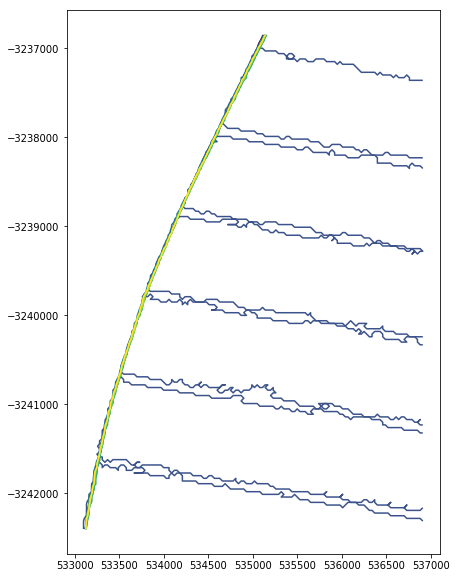

In [22]:
# Prepare attributes as input to contour extract
attribute_data = {'id_name': composite_ds.id_name.values.tolist()}  
attribute_dtypes = {'id_name': 'str'}

# Set threshold
thresh = 0

# Extract contours with custom attribute fields:
gdf = SpatialTools.contour_extract(z_values=[thresh],
                                   ds_array=composite_ds.mndwi,
                                   ds_crs=output_crs,
                                   ds_affine=all_ds.geobox.transform,
                                   output_shp=f'test2.shp',
                                   min_vertices=100,  
                                   attribute_data=attribute_data,
                                   attribute_dtypes=attribute_dtypes,
                                   verbose=False,                                   
                                   dim='id_name')

# Plot contours
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, cmap='viridis')

In [23]:
gdf

,id_name,geometry
0,2010-01-01,"LINESTRING (533130 -3242400, 533131.391403166 ..."
1,2011-01-01,"LINESTRING (533116.8819241908 -3242400, 533127..."
2,2012-01-01,"(LINESTRING (536910 -3238230, 536880 -3238230,..."
3,2013-01-01,"LINESTRING (533112.7413428181 -3242400, 533123..."
4,2014-01-01,"LINESTRING (533130.1793213377 -3242400, 533130..."
5,2015-01-01,"LINESTRING (533130.495803057 -3242400, 533133...."
6,2016-01-01,"LINESTRING (533128.2552671529 -3242400, 533130..."
7,2017-01-01,"LINESTRING (533124.1199736795 -3242400, 533127..."
8,2018-01-01,"LINESTRING (533125.2783189702 -3242400, 533126..."
